# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import ast
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [2]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

---

# Process Steps

In this notebook I'll go through the steps listed below:
* Business Understanding
* Data Understanding
* Data Wrangling
* Exploratory Analysis
* Modeling

---

# Business Understanding

In this project, I'll use the data provided by Starbucks to answer the following questions:
* What's the average age of Starbuck's customers?
* What are the most successful offers?
* What are the most successful offers for each age?
* What are the most successful offers for each gender?
* Can a Machine Learning model predict the customer behavior for a promotional offer?

---

# Data Understanding

First, I need to get an idea of the dataset provided by Starbucks to figure out which features are available and if I need to work on them to transform the dataset in a new dataset that better fits our needs. For instance, I need to know if the datasets contain **null** values, their sizes, the format and range of the values in the columns, the values distribution, find potential outliers, etc. 

In [3]:
#Check the dataset size 
portfolio.shape

(10, 6)

In [4]:
#Check the first rows of the dataset
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [5]:
# check the number of missing values
portfolio.isna().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [6]:
#check duplicated
portfolio.columns.duplicated().sum()

0

In [7]:
#type of offers
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fddf71aae48>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fddf718c278>]], dtype=object)

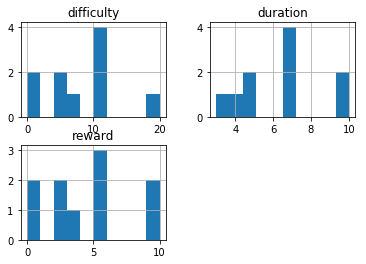

In [8]:
#portfolio dataset distribution of the numeric features
portfolio.hist()

In [9]:
# statistical values for each numeric feature
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


The exploration above shows that:
* There are 10 rows in the dataset
* There are 6 features
* The **portfolio** dataset doesn't have any missing value
* There are no duplicated
* There are 3 types of offers
* The most frequent difficulty is 10 and the most frequent duration is 7

In [10]:
#dataset size
profile.shape

(17000, 5)

In [11]:
#overview of the first rows of the dataset
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [12]:
#check if there are missing values in the columns
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [13]:
#check duplicated
profile.columns.duplicated().sum()

0

In [14]:
#check the values used to fill out the gender feature
profile.gender.unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [15]:
#check if the id are unique
profile.id.nunique()

17000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fddf7166128>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fddf70c67b8>]], dtype=object)

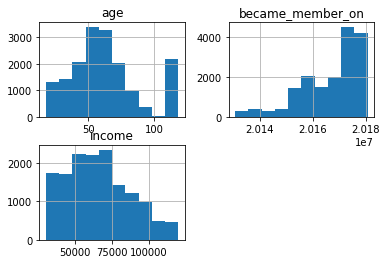

In [16]:
#profile dataset distribution of the numeric features
profile.hist()

In [17]:
# statistical values for each numeric feature
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


The exploration above shows that:
* There are 17000 rows in the dataset
* There are 5 features
* The **profile** dataset has missing values in the **gender** and **income** columns
* There are no duplicated
* There are 4 different values in the **gender** column, including the **None**
* 75% of the population is under 73 years old and earns up to 80000

In [18]:
#check the dataset size
transcript.shape

(306534, 4)

In [19]:
#check the first rows of the dataset
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [20]:
#check if there are missing values
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [21]:
#Check duplicated
transcript.columns.duplicated().sum()

0

In [22]:
#check the unique events 
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [23]:
#check how many unique person are available in the dataset
transcript.person.nunique()

17000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fddf70a0978>]], dtype=object)

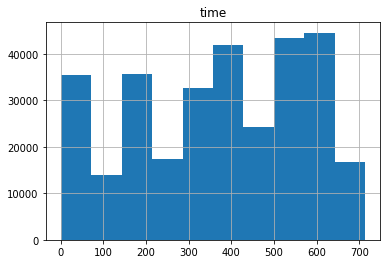

In [24]:
#distribution of the time since the start of the test
transcript.hist()

In [25]:
#check the stat values for the time column
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


The exploration above shows that:
* There are 306534 rows in the dataset
* There are 4 features
* The **transcript** dataset doesn't have any missing value
* There are no duplicated
* There are 4 different values in the **event** column
* 75% of the population has a test duration under 528 minutes

## Observations on the datasets

In the **portfolio** dataset, we have seen that channels feature contains a list of values. For our analysis it's better to transform it in a series of dummy variables.

In the **profile** dataset, we should handle the **null** values, and transform the string format in the **became_member_on** feature into a **date**.

In the **transcript** dataset, we should transform the values in the **value**. In fact, it seems to contain a sort of **dictionary** with one **key** and one **value**. It's better creating two columns that are specific to each value.

---

# Data Wrangling

In [26]:
#create dummy variables for the channels in the portfolio
dummies_channels = portfolio.channels.apply(pd.Series).stack().str.get_dummies().sum(level=0).add_prefix('dummy_')

In [27]:
#concatenate the dummy columns to the portfolio dataframe
portfolio = pd.concat([portfolio, dummies_channels], axis = 1)

In [28]:
#drop the channels column
portfolio = portfolio.drop(['channels'], axis=1)

In [29]:
portfolio

,difficulty,duration,id,offer_type,reward,dummy_email,dummy_mobile,dummy_social,dummy_web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


In [30]:
#check how many missing values there are in the dataset
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

I found some entries with an age of 118. Considering that a so high age could be an outlier, I check if 118 year old persons have missing or odd data in the other columns.

In [31]:
profile[profile.age == 118].isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

The rows with an age of 118 are the rows with **Null** values in the **gender** and **income**. For this reason, I treat them all as **outliers**, and I decide to remove the rows from the dataset.

In [32]:
profile.dropna(inplace=True)

In [33]:
#check how many rows left after removing the rows with 118 in the age column
profile.shape

(14825, 5)

In [34]:
#make sure there are no missing values now, after transforming data
profile.isna().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

Now the **profile** dataset doesn't have any missing values. We can take a glance at the distribution of the age of the customers that is relevant to my study.

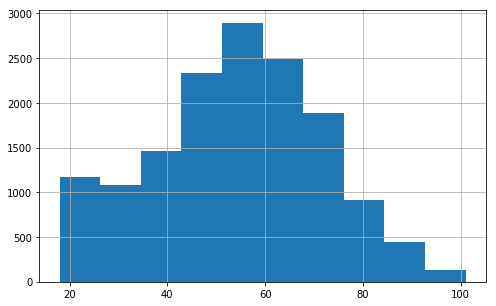

In [35]:
#Check the age distribution
profile.age.hist(figsize=(8,5))

In [36]:
#check stats about customers age
profile.age.describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

In [37]:
#Transform the became_member_on value (string) into a datetime and drop the became_member_on
profile['member_since_date'] = profile.became_member_on.apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
profile.drop(['became_member_on'], axis=1, inplace=True)

In [38]:
#check the new format of the profile dataset
profile.head()

,age,gender,id,income,member_since_date
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09
5,68,M,e2127556f4f64592b11af22de27a7932,70000.0,2018-04-26
8,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018-02-09
12,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017-11-11


In [39]:
#check the first rows of the transcript dataset
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [40]:
#check the value type of the value column
type(transcript.value[0])

dict

In [41]:
keys = []
for key, value in transcript.iterrows():
    for k in value['value']:
        if k in keys:
            continue
        else:
            keys.append(k)
keys

['offer id', 'amount', 'offer_id', 'reward']

In [42]:
def get_offer_id(value):
    offer_id = 0
    
    for key in value:
        if key == 'offer_id' or key == 'offer id': 
            offer_id = value[key]
    
    return offer_id

In [43]:
def get_amount(value):
    amount = 0
    
    for key in value:
        if key == 'amount':
            amount = value[key]
    
    return amount

In [44]:
def get_reward(value):
    reward = 0
    
    for key in value:
        if key == 'reward':
            reward = value[key]
    
    return reward

In [45]:
transcript['offer_id'] = transcript.value.apply(lambda v: get_offer_id(v))
transcript.head()

,event,person,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0


In [46]:
transcript['amount'] = transcript.value.apply(lambda v: get_amount(v))
transcript.head()

,event,person,time,value,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,0.0


In [47]:
transcript['reward'] = transcript.value.apply(lambda v: get_reward(v))
transcript.head()

,event,person,time,value,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,0.0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,0.0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0


In [48]:
#drop the value column
transcript.drop(['value'], axis=1, inplace=True)

In [49]:
#check the new format of the transcript dataset
transcript.head()

,event,person,time,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0


---

# Exploratory Analysis

## What's the average age of Starbucks' customers?

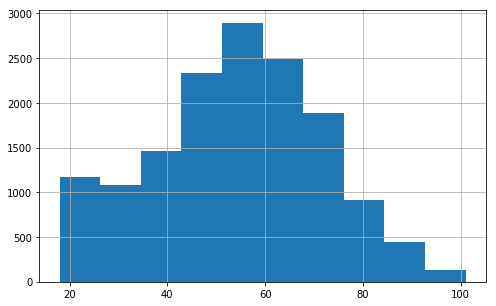

In [50]:
profile.age.hist(figsize=(8,5))

In [51]:
profile.age.describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

The mean age of a Starbucks customer is **54**. Below I show the detailed distribution that has a **Gaussian** shape centered on the mean value.

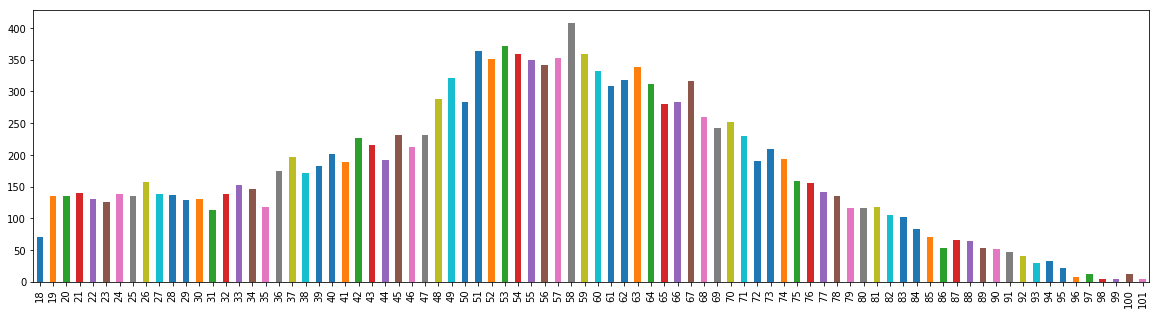

In [52]:
#check the detailed graph of the age distribution
profile.age.value_counts().sort_index(ascending=True).plot(kind='bar', figsize=(20, 5))

Text(0.5,0,'Gender')

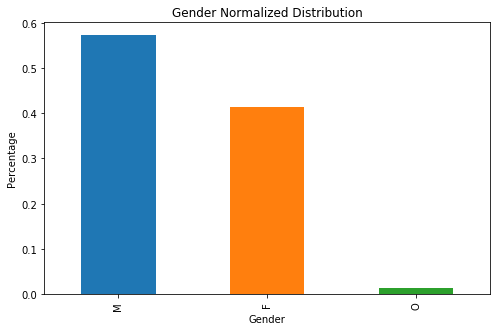

In [53]:
#Check the normalized distribution of the gender of the population in the profile dataset. 
#Remember that I replaced the missing values with the mode of the column
profile.gender.value_counts(normalize=True).plot(kind='bar', figsize=(8,5))
plt.title('Gender Normalized Distribution')
plt.ylabel('Percentage')
plt.xlabel('Gender')

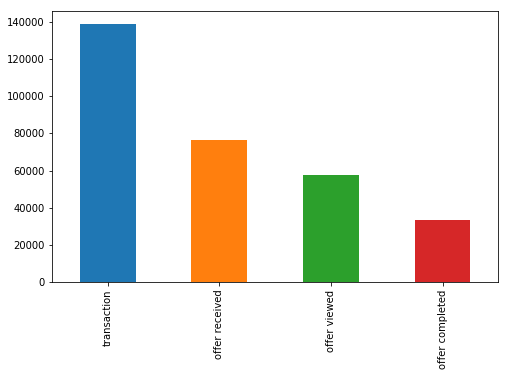

In [54]:
#check the distribution of the types of offers
transcript.event.value_counts().plot(kind='bar', figsize=(8,5))

## What are the most successfull offers?

In [55]:
#get the completed offers
transcript_offer_completed = transcript[transcript.event == 'offer completed']

In [56]:
transcript_offer_completed.shape

(33579, 6)

In [57]:
#get the viewed offers
transcript_offer_viewed = transcript[transcript.event == 'offer viewed']
transcript_offer_viewed.head()

,event,person,time,offer_id,amount,reward
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,5a8bc65990b245e5a138643cd4eb9837,0.0,0
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,0
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,5a8bc65990b245e5a138643cd4eb9837,0.0,0


In [58]:
transcript_offer_viewed.shape

(57725, 6)

In [59]:
#check the type of the most common offers completed
transcript_offer_received = transcript[transcript.event == 'offer received']

In [60]:
transcript_offer_completed_count = transcript_offer_completed.groupby('offer_id')['person'].count()
transcript_offer_received_count = transcript_offer_received.groupby('offer_id')['person'].count()
transcript_offer_success_rate = (transcript_offer_completed_count/transcript_offer_received_count*100).reset_index()
transcript_offer_success_rate.columns = ['offer_index', 'success_rate']
transcript_offer_success_rate

,offer_index,success_rate
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,44.600939
1,2298d6c36e964ae4a3e7e9706d1fb8c2,67.433952
2,2906b810c7d4411798c6938adc9daaa5,52.633648
3,3f207df678b143eea3cee63160fa8bed,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,43.869353
5,5a8bc65990b245e5a138643cd4eb9837,NaN
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,56.714863
7,ae264e3637204a6fb9bb56bc8210ddfd,48.158788
8,f19421c1d4aa40978ebb69ca19b0e20d,56.742835
9,fafdcd668e3743c1bb461111dcafc2a4,69.988153


In [61]:
transcript_offer_success_rate.dropna(inplace=True)
transcript_offer_success_rate

,offer_index,success_rate
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,44.600939
1,2298d6c36e964ae4a3e7e9706d1fb8c2,67.433952
2,2906b810c7d4411798c6938adc9daaa5,52.633648
4,4d5c57ea9a6940dd891ad53e9dbe8da0,43.869353
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,56.714863
7,ae264e3637204a6fb9bb56bc8210ddfd,48.158788
8,f19421c1d4aa40978ebb69ca19b0e20d,56.742835
9,fafdcd668e3743c1bb461111dcafc2a4,69.988153


In [62]:
transcript_offer_success_rate['offer_number'] = transcript_offer_success_rate.offer_index.apply(lambda x: portfolio[portfolio.id == x].index.values.astype(int)[0])

In [63]:
transcript_offer_success_rate = transcript_offer_success_rate.sort_values('success_rate')

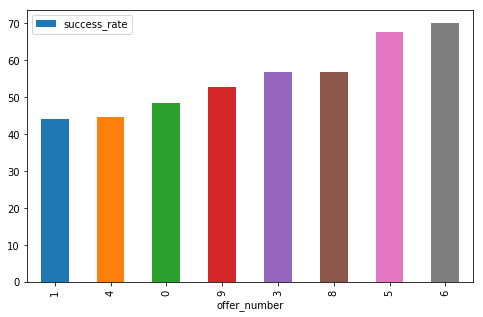

In [64]:
transcript_offer_success_rate.plot(x='offer_number', y='success_rate', kind='bar', figsize=(8, 5))

The bar chart above shows that the best offer in the portfolio, in terms of successfullness, is the number 6. After that, the most successful offers are the number 5, 8 and 3.

## What are the most successful offers for each age?

In [65]:
transcript_offer_completed_with_age = transcript_offer_completed.merge(profile[['id', 'age']], left_on='person', right_on='id', how='left').drop(['id'], axis=1)
transcript_offer_completed_with_age.dropna(inplace=True)
transcript_offer_completed_with_age.head()

,event,person,time,offer_id,amount,reward,age
0,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,0.0,2,42.0
1,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,2,39.0
2,offer completed,629fc02d56414d91bca360decdfa9288,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5,52.0
3,offer completed,676506bad68e4161b9bbaffeb039626b,0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,10,37.0
4,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,10,48.0


In [66]:
transcript_offer_completed_with_age_group_by_age = transcript_offer_completed_with_age.groupby(['offer_id','age'])['person'].count()

In [67]:
transcript_offer_received_with_age = transcript_offer_received.merge(profile[['id', 'age']], left_on='person', right_on='id', how='left').drop(['id'], axis=1)
transcript_offer_received_with_age.dropna(inplace=True)
transcript_offer_received_with_age.head()

,event,person,time,offer_id,amount,reward,age
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,75.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0,68.0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0,65.0
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0.0,0,58.0
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,61.0


In [68]:
transcript_offer_received_with_age_group_by_age = transcript_offer_received_with_age.groupby(['offer_id','age'])['person'].count()

In [69]:
transcript_offer_success_rate_by_age = (transcript_offer_completed_with_age_group_by_age/transcript_offer_received_with_age_group_by_age*100).reset_index()
transcript_offer_success_rate_by_age.dropna(inplace=True)

In [70]:
transcript_offer_success_rate_by_age = transcript_offer_success_rate_by_age.merge(portfolio[['id']], left_on='offer_id', right_on='id', how='left').drop('id', axis=1).sort_values(['offer_id', 'age']).dropna()
transcript_offer_success_rate_by_age.columns = ['offer_index', 'age', 'success_rate']
transcript_offer_success_rate_by_age['offer_number'] = transcript_offer_success_rate_by_age.offer_index.apply(lambda x: portfolio[portfolio.id == x].index.values.astype(int)[0])

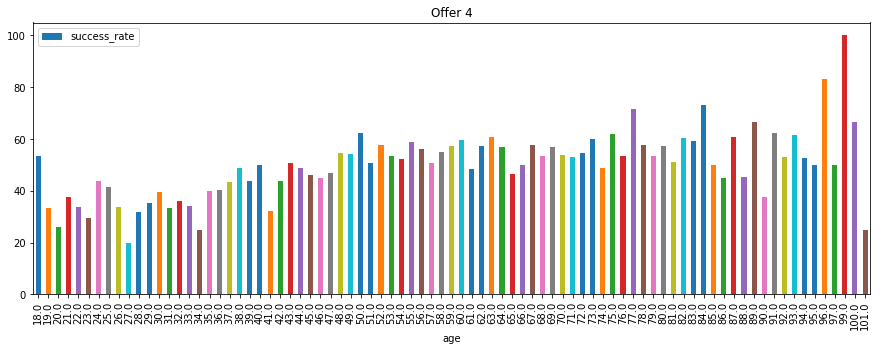

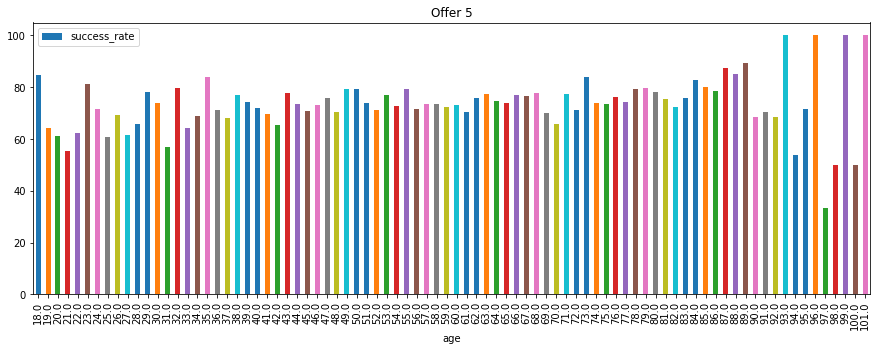

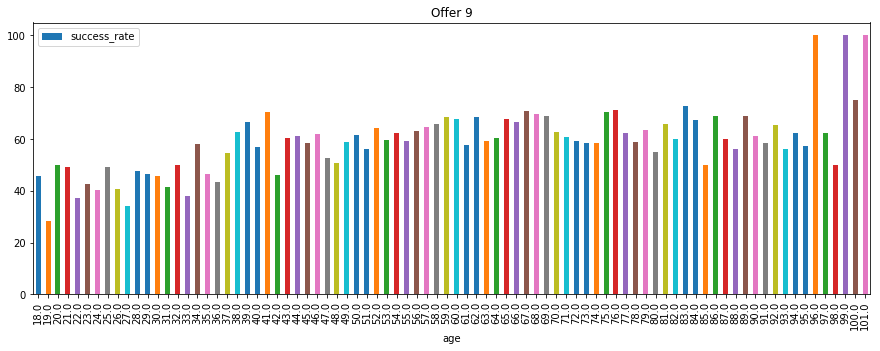

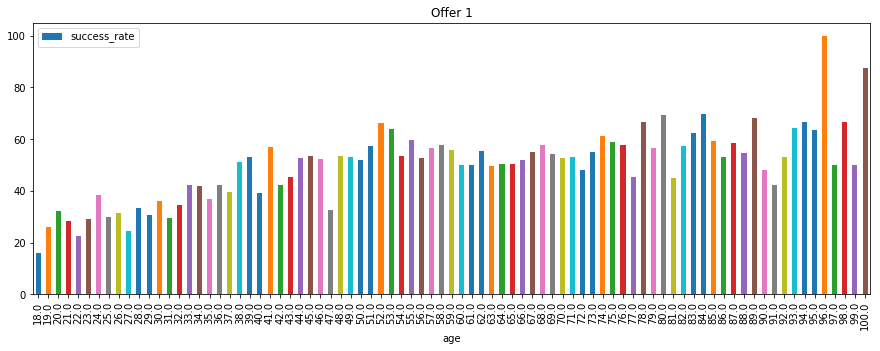

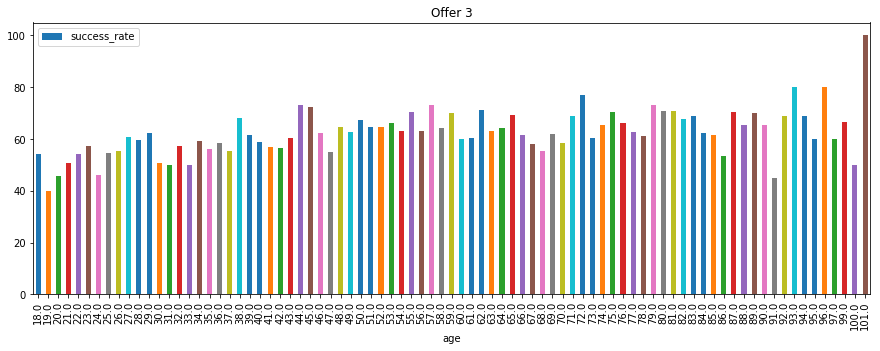

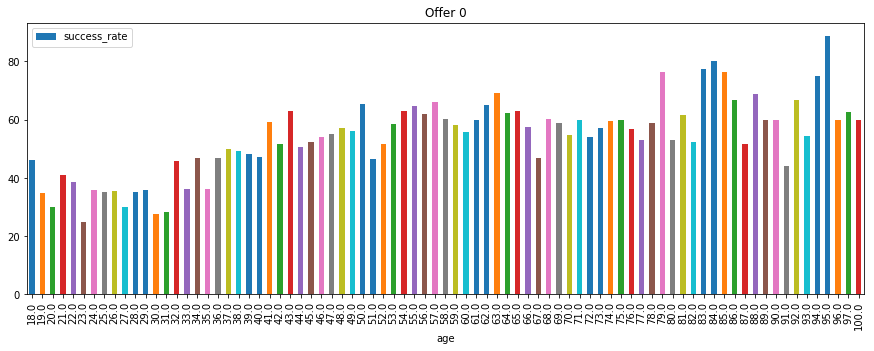

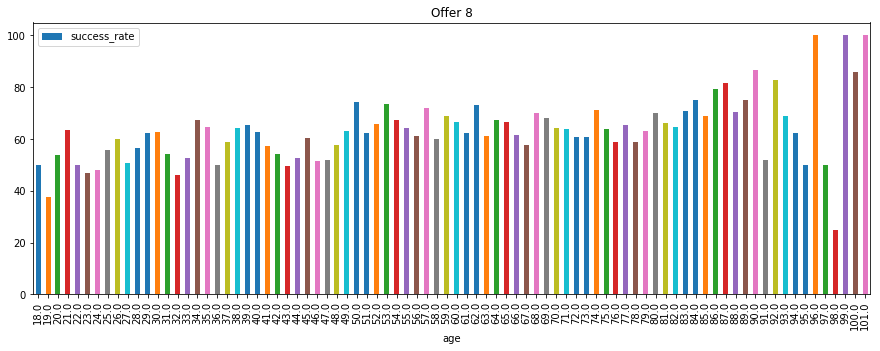

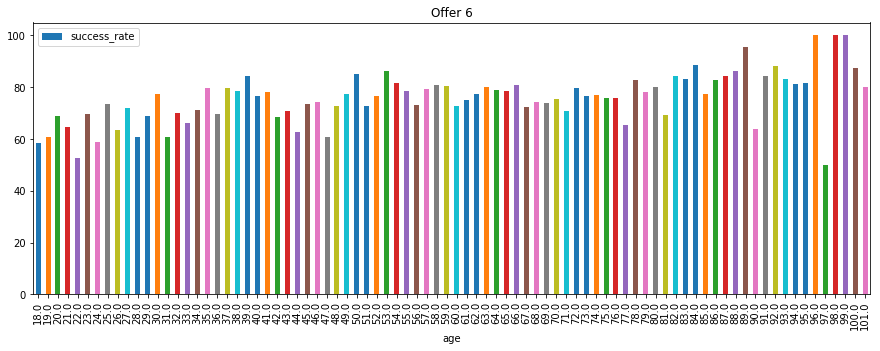

In [71]:
offers = transcript_offer_success_rate_by_age.offer_index.unique()

for offer in offers:
    transcript_offer_success_rate_by_age[transcript_offer_success_rate_by_age.offer_index == offer].plot(figsize=(15, 5), kind='bar', x='age', y='success_rate', title='offer_number')
    plt.title('Offer ' + str(portfolio[portfolio.id == offer].index.values.astype(int)[0]))

The division by age using all the possible ages is not very helpful, and probably not necessary because the variables we are working with do not change fast. For this reason, I decide to group the profiles by decades.

In [72]:
def get_decade(age):
    if (age >=0 and age <= 9):
        return '0-9'
    if (age >=10 and age<= 19):
        return '10-19'
    if (age >=20 and age<= 29):
        return '20-29'
    if (age >=30 and age<= 39):
        return '30-39'
    if (age >=40 and age<= 49):
        return '40-49'
    if (age >=50 and age<= 59):
        return '50-59'
    if (age >=60 and age<= 69):
        return '60-69'
    if (age >=70 and age<= 79):
        return '70-79'
    if (age >=80 and age<= 89):
        return '80-89'
    if (age >=90 and age<= 99):
        return '90-99'
    if (age >=100 and age<= 109):
        return '100-109'

In [73]:
transcript_offer_completed_with_age['age_group'] = transcript_offer_completed_with_age.age.apply(lambda x: get_decade(x))
transcript_offer_completed_with_age.head()

,event,person,time,offer_id,amount,reward,age,age_group
0,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,0.0,2,42.0,40-49
1,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,2,39.0,30-39
2,offer completed,629fc02d56414d91bca360decdfa9288,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5,52.0,50-59
3,offer completed,676506bad68e4161b9bbaffeb039626b,0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,10,37.0,30-39
4,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,10,48.0,40-49


In [74]:
transcript_offer_completed_with_age_group_by_decade = transcript_offer_completed_with_age.groupby(['offer_id','age_group'])['person'].count()
transcript_offer_completed_with_age_group_by_decade.head(20)

offer_id                          age_group
0b1e1539f2cc45b7b9fa7c272da2e1d7  10-19          31
                                  100-109         3
                                  20-29         207
                                  30-39         283
                                  40-49         485
                                  50-59         933
                                  60-69         712
                                  70-79         462
                                  80-89         210
                                  90-99          60
2298d6c36e964ae4a3e7e9706d1fb8c2  10-19          69
                                  100-109         2
                                  20-29         429
                                  30-39         506
                                  40-49         735
                                  50-59        1133
                                  60-69        1033
                                  70-79         589
                    

In [75]:
transcript_offer_received_with_age['age_group'] = transcript_offer_received_with_age.age.apply(lambda x: get_decade(x))
transcript_offer_received_with_age.head()

,event,person,time,offer_id,amount,reward,age,age_group
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,75.0,70-79
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0,68.0,60-69
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0,65.0,60-69
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0.0,0,58.0,50-59
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,61.0,60-69


In [76]:
transcript_offer_received_with_age_group_by_decade = transcript_offer_received_with_age.groupby(['offer_id','age_group'])['person'].count()
transcript_offer_received_with_age_group_by_decade.head(20)

offer_id                          age_group
0b1e1539f2cc45b7b9fa7c272da2e1d7  10-19          76
                                  100-109         7
                                  20-29         623
                                  30-39         718
                                  40-49        1012
                                  50-59        1692
                                  60-69        1294
                                  70-79         823
                                  80-89         368
                                  90-99         113
2298d6c36e964ae4a3e7e9706d1fb8c2  10-19          97
                                  100-109         3
                                  20-29         647
                                  30-39         703
                                  40-49        1006
                                  50-59        1522
                                  60-69        1383
                                  70-79         790
                    

In [77]:
transcript_offer_success_rate_by_decade = (transcript_offer_completed_with_age_group_by_decade/transcript_offer_received_with_age_group_by_decade*100).reset_index()
transcript_offer_success_rate_by_decade.dropna(inplace=True)
transcript_offer_success_rate_by_decade

,offer_id,age_group,person
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,10-19,40.789474
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,100-109,42.857143
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,20-29,33.226324
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,30-39,39.415042
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,40-49,47.924901
5,0b1e1539f2cc45b7b9fa7c272da2e1d7,50-59,55.141844
6,0b1e1539f2cc45b7b9fa7c272da2e1d7,60-69,55.023184
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,70-79,56.136087
8,0b1e1539f2cc45b7b9fa7c272da2e1d7,80-89,57.065217
9,0b1e1539f2cc45b7b9fa7c272da2e1d7,90-99,53.097345


In [78]:
transcript_offer_success_rate_by_decade = transcript_offer_success_rate_by_decade.merge(portfolio[['id']], left_on='offer_id', right_on='id', how='left').drop('id', axis=1).sort_values(['offer_id', 'age_group']).dropna()
transcript_offer_success_rate_by_decade.columns = ['offer_index', 'age_group', 'success_rate']
transcript_offer_success_rate_by_decade['offer_number'] = transcript_offer_success_rate_by_decade.offer_index.apply(lambda x: portfolio[portfolio.id == x].index.values.astype(int)[0])

In [79]:
transcript_offer_success_rate_by_decade.head()

,offer_index,age_group,success_rate,offer_number
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,10-19,40.789474,4
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,100-109,42.857143,4
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,20-29,33.226324,4
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,30-39,39.415042,4
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,40-49,47.924901,4


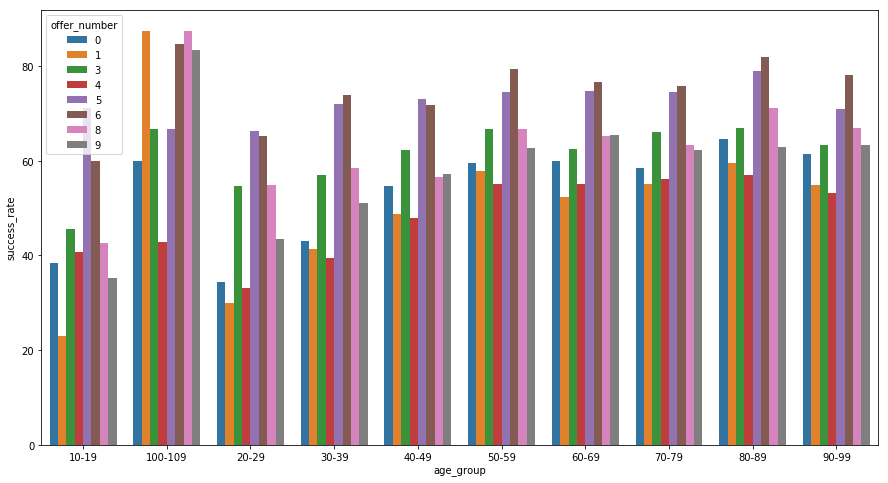

In [80]:
fig, ax = plt.subplots(figsize=(15,8))
sb.barplot(x='age_group', y='success_rate', data=transcript_offer_success_rate_by_decade, hue="offer_number", ax=ax)

The graph above shows the most successful offers for each **age group**, that are:

* 10-19: Offer 5
* 20-29: Offer 5
* 30-39: Offer 6
* 40-49: Offer 5
* 50-59: Offer 6
* 60-69: Offer 6
* 70-79: Offer 6
* 80-89: Offer 6
* 90-99: Offer 6
* 100-109: Offer 1 & 8 (draw)

That being said, the offer 6 is the best offer overall, because it has the higher success rate over each age group.

## What are the most successful offers for each gender?

In [81]:
transcript_offer_completed_with_gender = transcript_offer_completed.merge(profile[['id', 'gender']], left_on='person', right_on='id', how='left').drop(['id'], axis=1)
transcript_offer_completed_with_gender.dropna(inplace=True)
transcript_offer_completed_with_gender.head()

,event,person,time,offer_id,amount,reward,gender
0,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,0.0,2,M
1,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,2,F
2,offer completed,629fc02d56414d91bca360decdfa9288,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5,M
3,offer completed,676506bad68e4161b9bbaffeb039626b,0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,10,M
4,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,10,M


In [82]:
transcript_offer_completed_with_gender_group_by_gender = transcript_offer_completed_with_gender.groupby(['offer_id','gender'])['person'].count()

In [83]:
transcript_offer_received_with_gender = transcript_offer_received.merge(profile[['id', 'gender']], left_on='person', right_on='id', how='left').drop(['id'], axis=1)
transcript_offer_received_with_gender.dropna(inplace=True)
transcript_offer_received_with_gender.head()

,event,person,time,offer_id,amount,reward,gender
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,F
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0,M
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0,M
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0.0,0,M
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,F


In [84]:
transcript_offer_received_with_gender_group_by_gender = transcript_offer_received_with_gender.groupby(['offer_id','gender'])['person'].count()

In [85]:
transcript_offer_success_rate_by_gender = (transcript_offer_completed_with_gender_group_by_gender/transcript_offer_received_with_gender_group_by_gender*100).reset_index()
transcript_offer_success_rate_by_gender.dropna(inplace=True)
transcript_offer_success_rate_by_gender.head()

,offer_id,gender,person
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,60.799714
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,M,42.341871
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,O,63.636364
3,2298d6c36e964ae4a3e7e9706d1fb8c2,F,81.162620
4,2298d6c36e964ae4a3e7e9706d1fb8c2,M,67.958388


In [86]:
transcript_offer_success_rate_by_gender = transcript_offer_success_rate_by_gender.merge(portfolio[['id']], left_on='offer_id', right_on='id', how='left').drop('id', axis=1).sort_values(['offer_id', 'gender']).dropna()
transcript_offer_success_rate_by_gender.columns = ['offer_index', 'gender', 'success_rate']
transcript_offer_success_rate_by_gender['offer_number'] = transcript_offer_success_rate_by_gender.offer_index.apply(lambda x: portfolio[portfolio.id == x].index.values.astype(int)[0])

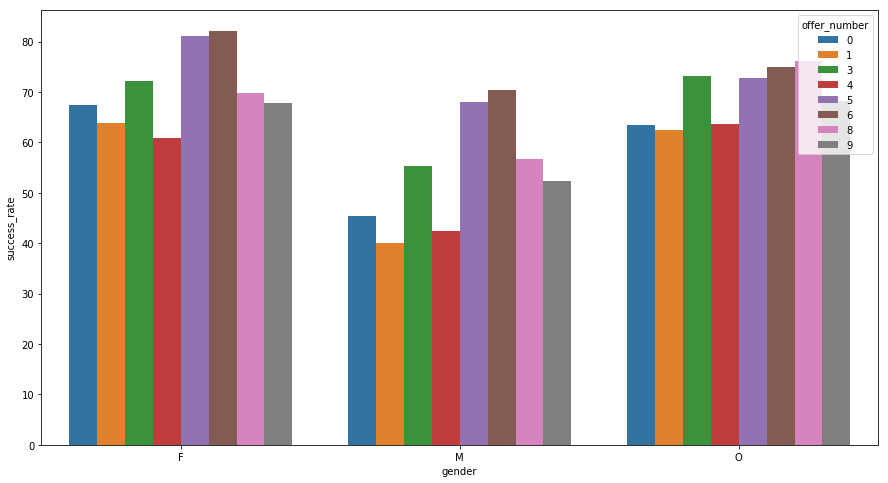

In [87]:
fig, ax = plt.subplots(figsize=(15,8))
sb.barplot(x='gender', y='success_rate', data=transcript_offer_success_rate_by_gender, hue="offer_number", ax=ax)

The graph above shows the most successful offers for each **gender**, that are:

* Female: Offer 6
* Male: Offer 6
* Other: Offer 8

That being said, the offer 8 seems to be effective only on those people with a **gender = O**, while the offer 6 seems to be most effective overall.

## Can a Machine Learning model predict the customer behavior for a promotional offer?

After the above analysis, I wanted to go on and try to find a model that can help me to predict the response of a customer to an offer. To do this, the first thing to do is to decide which are the covariates of the model, and which are the target variables we want to predict the value of.

In [88]:
profile.head()

,age,gender,id,income,member_since_date
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09
5,68,M,e2127556f4f64592b11af22de27a7932,70000.0,2018-04-26
8,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018-02-09
12,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017-11-11


In [89]:
portfolio

,difficulty,duration,id,offer_type,reward,dummy_email,dummy_mobile,dummy_social,dummy_web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


In [90]:
transcript.head()

,event,person,time,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0


I create one DataFrame containing all data from all Datasets. By doing this, I'll have all data already linked in a single raw. For this first approach, I decided to remove the rows containing missing values.

In [91]:
merged_df = transcript.merge(portfolio, how='left', left_on='offer_id', right_on='id')
merged_df.head()

,event,person,time,offer_id,amount,reward_x,difficulty,duration,id,offer_type,reward_y,dummy_email,dummy_mobile,dummy_social,dummy_web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,5.0,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,1.0,1.0,0.0,1.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,20.0,10.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5.0,1.0,0.0,0.0,1.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0,10.0,7.0,2906b810c7d4411798c6938adc9daaa5,discount,2.0,1.0,1.0,0.0,1.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0,10.0,10.0,fafdcd668e3743c1bb461111dcafc2a4,discount,2.0,1.0,1.0,1.0,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0,10.0,5.0,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10.0,1.0,1.0,1.0,1.0


In [92]:
merged_df = merged_df.merge(profile, how='left', left_on='person', right_on='id')
merged_df.head()

,event,person,time,offer_id,amount,reward_x,difficulty,duration,id_x,offer_type,reward_y,dummy_email,dummy_mobile,dummy_social,dummy_web,age,gender,id_y,income,member_since_date
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,5.0,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,1.0,1.0,0.0,1.0,75.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,20.0,10.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaT
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0,10.0,7.0,2906b810c7d4411798c6938adc9daaa5,discount,2.0,1.0,1.0,0.0,1.0,68.0,M,e2127556f4f64592b11af22de27a7932,70000.0,2018-04-26
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0,10.0,10.0,fafdcd668e3743c1bb461111dcafc2a4,discount,2.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaT
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0,10.0,5.0,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaT


In [93]:
merged_df = merged_df.dropna()
merged_df.head()

,event,person,time,offer_id,amount,reward_x,difficulty,duration,id_x,offer_type,reward_y,dummy_email,dummy_mobile,dummy_social,dummy_web,age,gender,id_y,income,member_since_date
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,5.0,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,1.0,1.0,0.0,1.0,75.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0,10.0,7.0,2906b810c7d4411798c6938adc9daaa5,discount,2.0,1.0,1.0,0.0,1.0,68.0,M,e2127556f4f64592b11af22de27a7932,70000.0,2018-04-26
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0,5.0,5.0,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,1.0,1.0,1.0,1.0,65.0,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018-02-09
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0.0,0,0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational,0.0,1.0,1.0,0.0,1.0,58.0,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017-11-11
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,20.0,10.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5.0,1.0,0.0,0.0,1.0,61.0,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0,2017-09-11


In [94]:
#remove the duplicated columns
merged_df.drop(['id_x', 'id_y'], axis=1, inplace=True)
#rename the columns
merged_df.columns=['event', 'profile_id', 'offer_time', 'offer_id', 'amount', 'reward', 'difficulty', 'duration', 'offer_type', 'offer_reward', 'email', 'mobile', 'social', 'web', 'age', 'gender', 'income', 'member_since_date']
merged_df

,event,profile_id,offer_time,offer_id,amount,reward,difficulty,duration,offer_type,offer_reward,email,mobile,social,web,age,gender,income,member_since_date
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,75.0,F,100000.0,2017-05-09
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0,68.0,M,70000.0,2018-04-26
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0,65.0,M,53000.0,2018-02-09
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0.0,0,0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0,58.0,M,51000.0,2017-11-11
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0,61.0,F,57000.0,2017-09-11
9,offer received,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0,62.0,F,71000.0,2016-02-11
12,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,0,10.0,7.0,bogo,10.0,1.0,1.0,1.0,0.0,64.0,M,100000.0,2017-09-09
13,offer received,c27e0d6ab72c455a8bb66d980963de60,0,3f207df678b143eea3cee63160fa8bed,0.0,0,0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0,78.0,F,71000.0,2017-06-16
14,offer received,d53717f5400c4e84affdaeda9dd926b3,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0,88.0,F,53000.0,2017-05-18
15,offer received,f806632c011441378d4646567f357a21,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0,42.0,M,69000.0,2013-08-11


In [95]:
#check the features, their type, and if we have missing values
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148805 entries, 0 to 306527
Data columns (total 18 columns):
event                148805 non-null object
profile_id           148805 non-null object
offer_time           148805 non-null int64
offer_id             148805 non-null object
amount               148805 non-null float64
reward               148805 non-null int64
difficulty           148805 non-null float64
duration             148805 non-null float64
offer_type           148805 non-null object
offer_reward         148805 non-null float64
email                148805 non-null float64
mobile               148805 non-null float64
social               148805 non-null float64
web                  148805 non-null float64
age                  148805 non-null float64
gender               148805 non-null object
income               148805 non-null float64
member_since_date    148805 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(10), int64(2), object(5)
memory usage: 21.6+ M

To help the model to work better, I transform the string values into numerical values.

In [96]:
def gender_to_numeric(gender):
    if (gender == 'O'):
        return 0
    if (gender == 'F'):
        return 1
    if (gender == 'M'):
        return 2

In [97]:
merged_df['gender'] = merged_df.gender.apply(lambda x: gender_to_numeric(x))
merged_df

,event,profile_id,offer_time,offer_id,amount,reward,difficulty,duration,offer_type,offer_reward,email,mobile,social,web,age,gender,income,member_since_date
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,75.0,1,100000.0,2017-05-09
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0,68.0,2,70000.0,2018-04-26
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0,65.0,2,53000.0,2018-02-09
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0.0,0,0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0,58.0,2,51000.0,2017-11-11
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0,61.0,1,57000.0,2017-09-11
9,offer received,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0,62.0,1,71000.0,2016-02-11
12,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,0,10.0,7.0,bogo,10.0,1.0,1.0,1.0,0.0,64.0,2,100000.0,2017-09-09
13,offer received,c27e0d6ab72c455a8bb66d980963de60,0,3f207df678b143eea3cee63160fa8bed,0.0,0,0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0,78.0,1,71000.0,2017-06-16
14,offer received,d53717f5400c4e84affdaeda9dd926b3,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0,88.0,1,53000.0,2017-05-18
15,offer received,f806632c011441378d4646567f357a21,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0,42.0,2,69000.0,2013-08-11


Transform the events into numerical values.

In [98]:
merged_df.event.unique()

array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

In [99]:
def event_to_numeric(event):
    if (event == 'offer received'):
        return 0
    if (event == 'offer viewed'):
        return 1
    if (event == 'transaction'):
        return 2
    if (event == 'offer completed'):
        return 3

In [100]:
merged_df['event'] = merged_df.event.apply(lambda x: event_to_numeric(x))
merged_df.head()

,event,profile_id,offer_time,offer_id,amount,reward,difficulty,duration,offer_type,offer_reward,email,mobile,social,web,age,gender,income,member_since_date
0,0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,75.0,1,100000.0,2017-05-09
2,0,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0,68.0,2,70000.0,2018-04-26
5,0,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0,65.0,2,53000.0,2018-02-09
7,0,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0.0,0,0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0,58.0,2,51000.0,2017-11-11
8,0,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0,61.0,1,57000.0,2017-09-11


Convert the offer types to numerical values.

In [101]:
merged_df.offer_type.unique()

array(['bogo', 'discount', 'informational'], dtype=object)

In [102]:
def offer_type_to_numeric(offer):
    if (offer == 'bogo'):
        return 0
    if (offer == 'discount'):
        return 1
    if (offer == 'informational'):
        return 2

In [103]:
merged_df['offer_type'] = merged_df.offer_type.apply(lambda x: offer_type_to_numeric(x))
merged_df.head()

,event,profile_id,offer_time,offer_id,amount,reward,difficulty,duration,offer_type,offer_reward,email,mobile,social,web,age,gender,income,member_since_date
0,0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,5.0,7.0,0,5.0,1.0,1.0,0.0,1.0,75.0,1,100000.0,2017-05-09
2,0,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0,10.0,7.0,1,2.0,1.0,1.0,0.0,1.0,68.0,2,70000.0,2018-04-26
5,0,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0,5.0,5.0,0,5.0,1.0,1.0,1.0,1.0,65.0,2,53000.0,2018-02-09
7,0,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0.0,0,0.0,4.0,2,0.0,1.0,1.0,0.0,1.0,58.0,2,51000.0,2017-11-11
8,0,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,20.0,10.0,1,5.0,1.0,0.0,0.0,1.0,61.0,1,57000.0,2017-09-11


In [109]:
#Create the X and Y datasets for the training and test phase. 
#Remove the Profile ID from the X dataset to remove any 1:1 correlation between a row and an event. As shown below,
# the X dataset contains only the covariates that I think could be relevant for the prediction
x_vars = ['difficulty', 'duration', 'amount','offer_reward', 'email', 'mobile', 'social', 'web', 'age', 'gender', 'income']
y_vars = ['event']

X = merged_df[x_vars]
Y = merged_df[y_vars]

In [110]:
X.head()

,difficulty,duration,amount,offer_reward,email,mobile,social,web,age,gender,income
0,5.0,7.0,0.0,5.0,1.0,1.0,0.0,1.0,75.0,1,100000.0
2,10.0,7.0,0.0,2.0,1.0,1.0,0.0,1.0,68.0,2,70000.0
5,5.0,5.0,0.0,5.0,1.0,1.0,1.0,1.0,65.0,2,53000.0
7,0.0,4.0,0.0,0.0,1.0,1.0,0.0,1.0,58.0,2,51000.0
8,20.0,10.0,0.0,5.0,1.0,0.0,0.0,1.0,61.0,1,57000.0


In [111]:
#normalize the values using the MinMaxScaler
scaler = MinMaxScaler()
features = ['amount', 'duration', 'difficulty', 'offer_reward']
X[features] = scaler.fit_transform(X[features])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [112]:
X.head()

,difficulty,duration,amount,offer_reward,email,mobile,social,web,age,gender,income
0,0.25,0.571429,0.0,0.5,1.0,1.0,0.0,1.0,75.0,1,100000.0
2,0.50,0.571429,0.0,0.2,1.0,1.0,0.0,1.0,68.0,2,70000.0
5,0.25,0.285714,0.0,0.5,1.0,1.0,1.0,1.0,65.0,2,53000.0
7,0.00,0.142857,0.0,0.0,1.0,1.0,0.0,1.0,58.0,2,51000.0
8,1.00,1.000000,0.0,0.5,1.0,0.0,0.0,1.0,61.0,1,57000.0


### Metrics selection

I'm trying to solve a **classification** problem, because I want to create a model to predict the **event** (which has a finite number of values) using the other features listed in the **x_vars** variable.

The metrics tha are typically used to assess the performance of a **classification model** are **accuracy**, **precision**, **recall**, and **F1-score**.

Accuracy is one metric for evaluating classification models. Informally, accuracy is the fraction of predictions our model got right. Considering that the **accuracy** is a reliable metric only when the dataset is **class-balanced**, we'll also have to make sure this is true for the Starbucks' dataset.

Finally, I'll go through some of the most common algorithms to solve classification problems. Then, I'll use the model with the best score to find if it can be improved using the **GridsearchCV**.


#### Events distribution: balancing

In [113]:
# Events type distribution in the Y dataset
(Y.squeeze().value_counts()/Y.squeeze().count())*100

0    44.690031
1    33.506939
3    21.803031
Name: event, dtype: float64

The **Y** dataset is not super balanced because the event types are not equally distributed.

Removing the **null** values from the **dataset** I lost all the **transaction** events, which is good because I don't want to predict if there was a transaction. Actually, I don't want to predict if the offer is received. Thus, I can remove the rows with **event** equal to 0. Let's see if the **Y** dataset becomes balanced.

In [114]:
merged_df = merged_df[merged_df.event != 0]
X = merged_df[x_vars]
Y = merged_df[y_vars]

In [115]:
(Y.squeeze().value_counts()/Y.squeeze().count())*100

1    60.580288
3    39.419712
Name: event, dtype: float64

The dataset is still not super-balanced, even though we can't consider it unbalanced. Thus, I'll calculate all metrics but I'll use the F1-score as metric to assess the performance of the model, because the F1-score in its **weighted** form allows to take into account of the balance of the dataset, and is more reliable than the **accuracy** when working with unbalanced classes.

Below is the function to calculate the F1-score.

In [116]:
def calc_metrics_score(model, X, y):
    y_pred = model.predict(X)
    
    accuracy_score_result = accuracy_score(y, y_pred)
    precision_score_result = precision_score(y, y_pred, average='weighted')
    recall_score_result = recall_score(y, y_pred, average='weighted')
    f1_score_result = f1_score(y, y_pred, average='weighted')
    
    print('Accuracy: {}, Precision: {}, Recall: {}, F1-Score: {}'.format(accuracy_score_result, 
                                                                         precision_score_result, 
                                                                         recall_score_result, 
                                                                         f1_score_result))
    
    return accuracy_score_result, precision_score_result, recall_score_result, f1_score_result

I also create a function to use the GridSearchCV to tune some hyperparameters and see the robustness of a model.

In [117]:
def grid_search_cv(X, y, classifier, params_grid, scoring_type, n_jobs_arg):
    grid_search_cv_model = GridSearchCV(classifier, params_grid, scoring=scoring_type, n_jobs=n_jobs_arg)
    grid_search_cv_model.fit(X, np.ravel(y))
    return grid_search_cv_model

### Creating datasets for training and test

In [118]:
#create the dataset for the training and test phase
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

### Logistic Regression Model

In [161]:
logistic_regression_model = LogisticRegression(random_state=42)
logistic_regression_model.fit(X_train, np.ravel(y_train))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [162]:
#logistic_regression_model.score(X_train, y_train)
logistic_regression_model_accuracy_train, logistic_regression_model_precision_train, logistic_regression_model_recall_train, logistic_regression_model_f1_train = calc_metrics_score(logistic_regression_model, X_train, y_train)

Accuracy: 0.5931991964748574, Precision: 0.5585590102676229, Recall: 0.5931991964748574, F1-Score: 0.5462153157442404


In [163]:
#logistic_regression_model.score(X_test, y_test)
logistic_regression_model_accuracy_test, logistic_regression_model_precision_test, logistic_regression_model_recall_test, logistic_regression_model_f1_test = calc_metrics_score(logistic_regression_model, X_test, y_test)

Accuracy: 0.5920489891135303, Precision: 0.5580551177562192, Recall: 0.5920489891135303, F1-Score: 0.54407965244264


In [164]:
params_grid = {
    'solver': ['saga', 'newton-cg'],
    'max_iter': [100, 1000, 2000]
}
n_jobs = -1
score_type = 'f1'

grid_search_cv_model = grid_search_cv(X_train, y_train, logistic_regression_model, params_grid, score_type, n_jobs)
grid_search_cv_model.best_score_

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.75500695831064324

In [165]:
#I create a dataframe with all the scores of the models
model_score_df = pd.DataFrame()
model_score_df['Logistic Regression'] = [logistic_regression_model_accuracy_train, logistic_regression_model_precision_train, logistic_regression_model_recall_train, logistic_regression_model_f1_train, logistic_regression_model_accuracy_test, logistic_regression_model_precision_test, logistic_regression_model_recall_test, logistic_regression_model_f1_test, grid_search_cv_model.best_score_]

### K Neighbors Classifier Model

In [166]:
k_neighbors_classifier_model = KNeighborsClassifier()
k_neighbors_classifier_model.fit(X_train, np.ravel(y_train))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [167]:
#k_neighbors_classifier_model.score(X_train, y_train)
k_neighbors_classifier_model_accuracy_train, k_neighbors_classifier_model_precision_train, k_neighbors_classifier_model_recall_train, k_neighbors_classifier_model_f1_train = calc_metrics_score(k_neighbors_classifier_model, X_train, y_train)

Accuracy: 0.6803395541731467, Precision: 0.6741665136440772, Recall: 0.6803395541731467, F1-Score: 0.6748445927143619


In [168]:
#k_neighbors_classifier_model.score(X_test, y_test)
k_neighbors_classifier_model_accuracy_test, k_neighbors_classifier_model_precision_test, k_neighbors_classifier_model_recall_test, k_neighbors_classifier_model_f1_test = calc_metrics_score(k_neighbors_classifier_model, X_test, y_test)

Accuracy: 0.49202954898911355, Precision: 0.47999470150173945, Recall: 0.49202954898911355, F1-Score: 0.4848211520913934


In [169]:
params_grid = {
    'n_neighbors': [5, 10, 20],
    'weights': ['uniform', 'distance']
}
n_jobs = -1
score_type = 'f1'

grid_search_cv_model = grid_search_cv(X_train, y_train, k_neighbors_classifier_model, params_grid, score_type, n_jobs)
grid_search_cv_model.best_score_

0.69900865099542631

In [170]:
#I create a dataframe with all the scores of the models
model_score_df['K Neighbors Classifier'] = [k_neighbors_classifier_model_accuracy_train, k_neighbors_classifier_model_precision_train, k_neighbors_classifier_model_recall_train, k_neighbors_classifier_model_f1_train, k_neighbors_classifier_model_accuracy_test, k_neighbors_classifier_model_precision_test, k_neighbors_classifier_model_recall_test, k_neighbors_classifier_model_f1_test, grid_search_cv_model.best_score_]

### Naive Bayes Model

For this model, I won't use the GridSearchCV, because I don't need to find the optimal model by changing the **priors** for the **classes**.

In [171]:
gaussian_naive_bayes_model = GaussianNB()
gaussian_naive_bayes_model.fit(X_train, np.ravel(y_train))

GaussianNB(priors=None)

In [172]:
#gaussian_naive_bayes_model.score(X_train, y_train)
gaussian_naive_bayes_modelaccuracy_train, gaussian_naive_bayes_model_precision_train, gaussian_naive_bayes_model_recall_train, gaussian_naive_bayes_model_f1_train = calc_metrics_score(gaussian_naive_bayes_model, X_train, y_train)

Accuracy: 0.6126393208916537, Precision: 0.5982711350827027, Recall: 0.6126393208916537, F1-Score: 0.5993310344440237


In [173]:
#gaussian_naive_bayes_model.score(X_test, y_test)
gaussian_naive_bayes_modelaccuracy_test, gaussian_naive_bayes_model_precision_test, gaussian_naive_bayes_model_recall_test, gaussian_naive_bayes_model_f1_test = calc_metrics_score(gaussian_naive_bayes_model, X_test, y_test)

Accuracy: 0.6126069206842923, Precision: 0.5982991461625229, Recall: 0.6126069206842923, F1-Score: 0.5987725121006022


In [174]:
#I create a dataframe with all the scores of the models
model_score_df['Naive Bayes'] = [gaussian_naive_bayes_modelaccuracy_train, gaussian_naive_bayes_model_precision_train, gaussian_naive_bayes_model_recall_train, gaussian_naive_bayes_model_f1_train, gaussian_naive_bayes_modelaccuracy_test, gaussian_naive_bayes_model_precision_test, gaussian_naive_bayes_model_recall_test, gaussian_naive_bayes_model_f1_test, 0]

### Decision Tree Classifier Model

In [175]:
decision_tree_classifier_model = DecisionTreeClassifier(random_state=42)
decision_tree_classifier_model.fit(X_train, np.ravel(y_train))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [176]:
#decision_tree_classifier_model.score(X_train, y_train)
decision_tree_classifier_model_accuracy_train, decision_tree_classifier_model_precision_train, decision_tree_classifier_model_recall_train, decision_tree_classifier_model_f1_train = calc_metrics_score(decision_tree_classifier_model, X_train, y_train)

Accuracy: 0.7271902540176257, Precision: 0.7499915820370234, Recall: 0.7271902540176257, F1-Score: 0.6991954503213846


In [177]:
#decision_tree_classifier_model.score(X_test, y_test)
decision_tree_classifier_model_accuracy_test, decision_tree_classifier_model_precision_test, decision_tree_classifier_model_recall_test, decision_tree_classifier_model_f1_test = calc_metrics_score(decision_tree_classifier_model, X_test, y_test)

Accuracy: 0.42219090202177295, Precision: 0.38974656676501035, Recall: 0.42219090202177295, F1-Score: 0.4026046201545199


In [178]:
params_grid = {
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}
n_jobs = -1
score_type = 'f1'

grid_search_cv_model = grid_search_cv(X_train, y_train, decision_tree_classifier_model, params_grid, score_type, n_jobs)
grid_search_cv_model.best_score_

0.59367468369261289

In [179]:
#I create a dataframe with all the scores of the models
model_score_df['Decision Tree Classifier'] = [decision_tree_classifier_model_accuracy_train, decision_tree_classifier_model_precision_train, decision_tree_classifier_model_recall_train, decision_tree_classifier_model_f1_train, decision_tree_classifier_model_accuracy_test, decision_tree_classifier_model_precision_test, decision_tree_classifier_model_recall_test, decision_tree_classifier_model_f1_test, grid_search_cv_model.best_score_]

### Random Forest Classifier Model

In [180]:
random_forest_classifier_model = RandomForestClassifier(random_state=42)
random_forest_classifier_model.fit(X_train, np.ravel(y_train))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [181]:
#random_forest_classifier_model.score(X_train, y_train)
random_forest_classifier_model_accuracy_train, random_forest_classifier_model_precision_train, random_forest_classifier_model_recall_train, random_forest_classifier_model_f1_train = calc_metrics_score(random_forest_classifier_model, X_train, y_train)

Accuracy: 0.7200784085018144, Precision: 0.7167509720707398, Recall: 0.7200784085018144, F1-Score: 0.7175346317535856


In [182]:
#random_forest_classifier_model.score(X_test, y_test)
random_forest_classifier_model_accuracy_test, random_forest_classifier_model_precision_test, random_forest_classifier_model_recall_test, random_forest_classifier_model_f1_test = calc_metrics_score(random_forest_classifier_model, X_test, y_test)

Accuracy: 0.4233087091757387, Precision: 0.41715152786713094, Recall: 0.4233087091757387, F1-Score: 0.42002359462716643


In [183]:
params_grid = {
    'n_estimators': [10, 100, 1000],
    'max_depth': [2, 5, 10]
}
n_jobs = -1
score_type = 'f1'

grid_search_cv_model = grid_search_cv(X_train, y_train, random_forest_classifier_model, params_grid, score_type, n_jobs)
grid_search_cv_model.best_score_

0.75431939474738074

In [184]:
#I create a dataframe with all the scores of the models
model_score_df['Random Forest Classifier'] = [random_forest_classifier_model_accuracy_train, random_forest_classifier_model_precision_train, random_forest_classifier_model_recall_train, random_forest_classifier_model_f1_train, random_forest_classifier_model_accuracy_test, random_forest_classifier_model_precision_test, random_forest_classifier_model_recall_test, random_forest_classifier_model_f1_test, grid_search_cv_model.best_score_]

### Gradient Boost Classifier Model

In [185]:
gradient_boost_classifier_model = GradientBoostingClassifier(random_state=42)
gradient_boost_classifier_model.fit(X_train, np.ravel(y_train))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [186]:
#gradient_boost_classifier_model.score(X_train, np.ravel(y_train))
gradient_boost_classifier_model_accuracy_train, gradient_boost_classifier_model_precision_train, gradient_boost_classifier_model_recall_train, gradient_boost_classifier_model_f1_train = calc_metrics_score(gradient_boost_classifier_model, X_train, y_train)

Accuracy: 0.6346228615863142, Precision: 0.6198070990986343, Recall: 0.6346228615863142, F1-Score: 0.614048291025379


In [187]:
#gradient_boost_classifier_model.score(X_test, np.ravel(y_test))
gradient_boost_classifier_model_accuracy_test, gradient_boost_classifier_model_precision_test, gradient_boost_classifier_model_recall_test, gradient_boost_classifier_model_f1_test = calc_metrics_score(gradient_boost_classifier_model, X_test, y_test)

Accuracy: 0.6331648522550545, Precision: 0.6186509549032156, Recall: 0.6331648522550545, F1-Score: 0.6116588821635761


In [188]:
params_grid = {
    # Learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators.
    'learning_rate': [0.01, 0.1, 1],
    # The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
    'n_estimators': [10, 100, 1000]
}
n_jobs = -1
score_type = 'f1'

grid_search_cv_model = grid_search_cv(X_train, y_train, gradient_boost_classifier_model, params_grid, score_type, n_jobs)
grid_search_cv_model.best_score_

0.75500695831064324

In [189]:
#I create a dataframe with all the scores of the models
model_score_df['Gradient Boost Classifier'] = [gradient_boost_classifier_model_accuracy_train, gradient_boost_classifier_model_precision_train, gradient_boost_classifier_model_recall_train, gradient_boost_classifier_model_f1_train, gradient_boost_classifier_model_accuracy_test, gradient_boost_classifier_model_precision_test, gradient_boost_classifier_model_recall_test, gradient_boost_classifier_model_f1_test, grid_search_cv_model.best_score_]

## Results

Now that we have trained and tested the models, we can compare the performance of each model to see which one had the best performance overall. I'll use a **Bar Graph**, a **Table** showing the metrics value, and the standard deviation between the performance for each model.

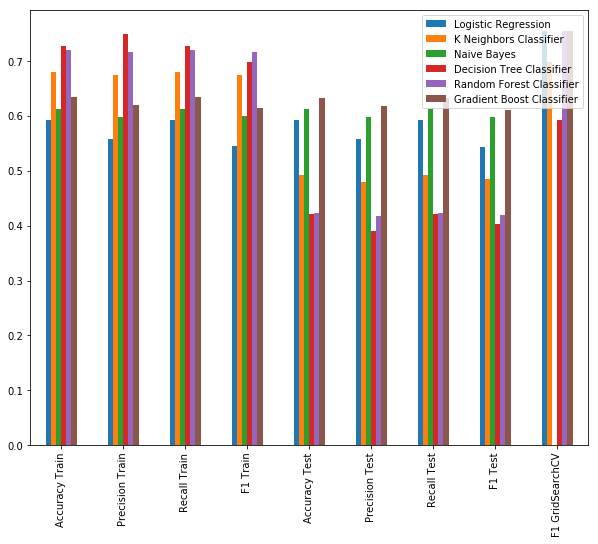

In [201]:
models_label = ['Metric', 
                'Logistic Regression', 
                'K Neighbors Classifier', 
                'Naive Bayes', 
                'Decision Tree', 
                'Random Forest Classifier', 
                'Gradient Boost Classifier']

metrics = ['Accuracy Train', 'Precision Train', 'Recall Train', 'F1 Train',
           'Accuracy Test', 'Precision Test', 'Recall Test', 'F1 Test',
           'F1 GridSearchCV']

model_score_df.index = metrics

model_score_df.plot(figsize=(10, 8), kind='bar')

In [203]:
model_score_df

,Logistic Regression,K Neighbors Classifier,Naive Bayes,Decision Tree Classifier,Random Forest Classifier,Gradient Boost Classifier
Accuracy Train,0.593199,0.680340,0.612639,0.727190,0.720078,0.634623
Precision Train,0.558559,0.674167,0.598271,0.749992,0.716751,0.619807
Recall Train,0.593199,0.680340,0.612639,0.727190,0.720078,0.634623
F1 Train,0.546215,0.674845,0.599331,0.699195,0.717535,0.614048
Accuracy Test,0.592049,0.492030,0.612607,0.422191,0.423309,0.633165
Precision Test,0.558055,0.479995,0.598299,0.389747,0.417152,0.618651
Recall Test,0.592049,0.492030,0.612607,0.422191,0.423309,0.633165
F1 Test,0.544080,0.484821,0.598773,0.402605,0.420024,0.611659
F1 GridSearchCV,0.755007,0.699009,0.000000,0.593675,0.754319,0.755007


In [204]:
model_score_df.describe()

,Logistic Regression,K Neighbors Classifier,Naive Bayes,Decision Tree Classifier,Random Forest Classifier,Gradient Boost Classifier
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,0.592490,0.595286,0.538352,0.570442,0.590284,0.639416
std,0.064455,0.102833,0.202003,0.159402,0.161056,0.044321
min,0.544080,0.479995,0.000000,0.389747,0.417152,0.611659
25%,0.558055,0.492030,0.598299,0.422191,0.423309,0.618651
50%,0.592049,0.674167,0.599331,0.593675,0.716751,0.633165
75%,0.593199,0.680340,0.612607,0.727190,0.720078,0.634623
max,0.755007,0.699009,0.612639,0.749992,0.754319,0.755007


The best model overall in terms of **F1-Score** is the **Gradient Boost Classifier** (along with the **Logistic Regression**). The **Random Forest Classifier** was good too. However, the **Gradient Boost Classifier** is the best model when it comes to predicting events on unseen data, and the standard deviation between the scores of the **Gradient Boost Classifier** is the lowest. It means the **Gradient Boost Classifier** is the model that has the lower risk of **overfitting** data. This make it a robust model we can rely on.

### Best model robustness: Can the best model be improved by auto tuning some of the training parameters?

I've found that the best model in terms of **F1-score** for both the train and test datasets is the **Gradient Boost Classifier**. I want to experiment if there's a better set of **hyperparameters** that improves the model performance. To do this I take advantage of the cross-validation **GridsearchCV** one more time.

In [207]:
classifier = gradient_boost_classifier_model
params_grid = {
    # Learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators.
    'learning_rate': [0.01, 0.1, 1],
    # The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
    'n_estimators': [10, 100, 1000],
    # The loss function to be optimized. ‘deviance’ refers to deviance (= logistic regression) for classification with probabilistic outputs. 
    #For loss ‘exponential’ gradient boosting recovers the AdaBoost algorithm.
    'loss': ['deviance', 'exponential'],
    # The maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree. 
    #Tune this parameter for best performance; the best value depends on the interaction of the input variables.
    'max_depth': [2, 3, 5]
    
}
score_type = 'f1'
n_jobs = -1

grid_search_cv_model = grid_search_cv(X_train, y_train, classifier, params_grid, score_type, n_jobs)
grid_search_cv_model.best_score_

0.75500695831064324

In [143]:
# get the best accuracy found using the GridSearchCV on test data
grid_search_cv_model = grid_search_cv(X_test, y_test, classifier, params_grid, score_type, n_jobs)
grid_search_cv_model.best_score_

0.75304526914850722

The performance on the **train** dataset is the same, but the model does better with new data. It means we have found an improved model that is capable of predicting events with better perforamance when it will be deployed in production.

Below are the hyperparameters of the improved version of the **Gradient Boost Classifier Model**.

In [208]:
grid_search_cv_model

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.01, 0.1, 1], 'n_estimators': [10, 100, 1000], 'loss': ['deviance', 'exponential'], 'max_depth': [2, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

## Conclusions and improvements

The study showed that:

* The offer with the best **success rate** overall is the **offer 6**. Thus, if Starbucks want to focus on a specific offer, that offer is definitely the number 6.
* The best offer for people under 30 is the offer 5
* The best offer for people above 30 is the offer 6
* The best offers for very old people are the number 1 and 8.
* The best offer for both male and female customers is the offer 6
* The best offer for people that are not male or female is the offer number 8
* It's possible to predict if a customer will **view** or **complete** an offer. I've tried applying many different classification algorithms and used the **F1-Score** metric to evaluate the performance of the models to decide which one is the best model. I've opted for the **F1-Score** because the datased is not fully balanced, and I didn't want to use the **accuracy** which is unreliable when working with unbalanced datasets. The **F1-Score** is a statistical combination of the **precision** and **recall**, and for this reason it's a metric tailored to be used when working with unbalanced datasets.
* The best performance, considering both the **training** and **test** datasets, is obtained using the **Gradient Boost Classifier Model** with:
    * Learning rate = 0.1
    * loss = deviance
    * max_depth = 3
    * n_estimators = 100
    

One thing that surprised me was to find out that people between **100-109** like the people with a gender **other** usually prefer the **offer 8**. In the next study, I could check if there's a correlation between those groups of people.

Future improvements could be done by including other **features** in the X dataset to see if they help to improve the performance of the models. In fact, I've not considered the **age_group** to calculate the prediction model. Considering the **age group** instead the specific age of each customer could help to aggregate and normalize data, and the model could benefit from this.